In [17]:
import os
import re
import numpy as np
SETS = ['training', 'validation', 'tests']
FEATURES = ['dwt', 'dtcwt']
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
models_path = 'models'
dataset_genres_path = '../genres'

### Load the dataset

In [6]:
def load_dataset():       
    X_paths = []
    y  = []      
    for genre in GENRES:
        for wav in os.listdir(os.path.join(dataset_genres_path,genre)):            
            if wav == 'jazz.00054.wav': continue
            matched = re.match(r"(\w+).(\d+).wav", wav)
            if matched:
                path = os.path.join(dataset_genres_path,os.path.join(genre,wav))
                y.append(genre)
                X_paths.append(path)
    return X_paths, y


In [7]:
X_paths, y = load_dataset()
X_paths, y

(['../genres\\blues\\blues.00000.wav',
  '../genres\\blues\\blues.00001.wav',
  '../genres\\blues\\blues.00002.wav',
  '../genres\\blues\\blues.00003.wav',
  '../genres\\blues\\blues.00004.wav',
  '../genres\\blues\\blues.00005.wav',
  '../genres\\blues\\blues.00006.wav',
  '../genres\\blues\\blues.00007.wav',
  '../genres\\blues\\blues.00008.wav',
  '../genres\\blues\\blues.00009.wav',
  '../genres\\blues\\blues.00010.wav',
  '../genres\\blues\\blues.00011.wav',
  '../genres\\blues\\blues.00012.wav',
  '../genres\\blues\\blues.00013.wav',
  '../genres\\blues\\blues.00014.wav',
  '../genres\\blues\\blues.00015.wav',
  '../genres\\blues\\blues.00016.wav',
  '../genres\\blues\\blues.00017.wav',
  '../genres\\blues\\blues.00018.wav',
  '../genres\\blues\\blues.00019.wav',
  '../genres\\blues\\blues.00020.wav',
  '../genres\\blues\\blues.00021.wav',
  '../genres\\blues\\blues.00022.wav',
  '../genres\\blues\\blues.00023.wav',
  '../genres\\blues\\blues.00024.wav',
  '../genres\\blues\\blue

### Extract Descrete Wavelet Transform (DWT) features

In [20]:
from mugenfier.features import wavelets_extraction

X_features = []
for wav in X_paths:
    features = wavelets_extraction.extract_dwt(wav)
    X_features.append(features)

X_dwt = np.array(X_features)
y_dwt = np.array(y)

### Extract Dual-Tree Complex Wavelet Transform (DT-CWT) features

In [21]:
from mugenfier.features import wavelets_extraction

X_features = []
for wav in X_paths:
    features = wavelets_extraction.extract_dtcwt(wav)
    X_features.append(features)

X_dtcwt = np.array(X_features)
y_dtcwt = np.array(y)

Save the features if desired

In [22]:
np.save('dtcwt_15_lvl17', X_dtcwt)
np.save('dtcwt_y', y_dtcwt)

np.save('dwt_db12', X_dwt)
np.save('dwt_y', y_dwt)

In [23]:
X_dtcwt = np.load('dtcwt_15_lvl17.npy')
y_dtcwt = np.load('dtcwt_y.npy')

X_dwt = np.load('dwt_db12.npy')
y_dwt = np.load('dwt_y.npy')

### Use the generic split.
Score the model on that split with validation set, test set and both together. That way the results can be compared with other models or other features, don't matter on wich set they evaluate themself.

In [25]:
from mugenfier.datasets import random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# ------ DWT ------ 

encoder = LabelEncoder()
y_dwt = encoder.fit_transform(y_dwt)
scaler = StandardScaler()
X_dwt_scaled = scaler.fit_transform(X_dwt)

X_train_dwt, y_train_dwt, X_validation_dwt, y_validation_dwt, X_test_dwt, y_test_dwt = random_split.generic_random_split(X_dwt_scaled, y_dwt)
X_train_dwt.shape, y_train_dwt.shape, X_validation_dwt.shape, y_validation_dwt.shape, X_test_dwt.shape, y_test_dwt.shape

((799, 180), (799,), (100, 180), (100,), (100, 180), (100,))

In [27]:
from mugenfier.datasets import random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# ------ DT-CWT ------ 

encoder = LabelEncoder()
y_dtcwt = encoder.fit_transform(y_dtcwt)
scaler = StandardScaler()
X_dtcwt_scaled = scaler.fit_transform(X_dtcwt)

X_train_dtcwt, y_train_dtcwt, X_validation_dtcwt, y_validation_dtcwt, X_test_dtcwt, y_test_dtcwt = random_split.generic_random_split(X_dtcwt_scaled, y_dtcwt)
X_train_dtcwt.shape, y_train_dtcwt.shape, X_validation_dtcwt.shape, y_validation_dtcwt.shape, X_test_dtcwt.shape, y_test_dtcwt.shape

((799, 216), (799,), (100, 216), (100,), (100, 216), (100,))

In [29]:
X_val_test_dwt = np.concatenate((X_validation_dwt, X_test_dwt))
y_val_test_dwt = np.concatenate((y_validation_dwt, y_test_dwt))

In [30]:
X_val_test_dtcwt = np.concatenate((X_validation_dtcwt, X_test_dtcwt))
y_val_test_dtcwt = np.concatenate((y_validation_dtcwt, y_test_dtcwt))

Select models to test the features

In [58]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
rf_cls = RandomForestClassifier(n_estimators=100,max_depth=13,bootstrap=False,random_state=13)
gb_cls = GradientBoostingClassifier(n_estimators=1000,random_state=13)

lr = LogisticRegression(random_state=13,max_iter=2000)
lsvc = LinearSVC(random_state=13,max_iter=12000)
svc = SVC(random_state=13,max_iter=10000)

models = [rf_cls, gb_cls, lr, lsvc, svc]
feat = {
        # 'dwt train':(X_train_dwt,y_train_dwt),
        # 'dwt test':(X_val_test_dwt,y_val_test_dwt),
        # 'dtcwt train':(X_train_dtcwt,y_train_dtcwt),
        # 'dtcwt test':(X_val_test_dtcwt,y_val_test_dtcwt),
        'dwt':(X_dwt_scaled,y_dwt),
        'dtcwt':(X_dtcwt_scaled,y_dtcwt)
        }
models_str = ['RandomForestClassifier', 'GradientBoostingClassifier', 'LogisticRegression', 'LinearSVC', 'SVC']

In [60]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

results = pd.DataFrame(columns=FEATURES,index=models_str) #.set_index('mean_accuracy')

for i, model in enumerate(models):
    for feature in FEATURES:

        strKfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        scores = cross_val_score(model,feat[feature][0], feat[feature][1], cv=strKfold)

        print(f'{models_str[i]} {feature} :\n\tscores: ', scores)
        print('\tmean: ', scores.mean())
        print('\tstd: ', scores.std())

        results.loc[models_str[i],feature] = round(scores.mean(),4)

print(results)



RandomForestClassifier dwt :
	scores:  [0.745      0.76       0.775      0.755      0.70854271]
	mean:  0.7487085427135678
	std:  0.02229514426373974
RandomForestClassifier dtcwt :
	scores:  [0.735      0.775      0.785      0.765      0.70351759]
	mean:  0.7527035175879397
	std:  0.029745821871994614
GradientBoostingClassifier dwt :
	scores:  [0.79       0.74       0.765      0.74       0.71356784]
	mean:  0.749713567839196
	std:  0.02589166709169678
GradientBoostingClassifier dtcwt :
	scores:  [0.78       0.76       0.775      0.72       0.69849246]
	mean:  0.7466984924623116
	std:  0.03201101897353231
LogisticRegression dwt :
	scores:  [0.685      0.695      0.675      0.715      0.65829146]
	mean:  0.6856582914572863
	std:  0.019032495977505393
LogisticRegression dtcwt :
	scores:  [0.745      0.72       0.725      0.755      0.70351759]
	mean:  0.7297035175879396
	std:  0.018307805108359086
LinearSVC dwt :
	scores:  [0.635      0.665      0.67       0.695      0.65326633]
	mean:  0

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC dtcwt :
	scores:  [0.735      0.72       0.715      0.745      0.69849246]
	mean:  0.7226984924623115
	std:  0.01613173809342316
SVC dwt :
	scores:  [0.615      0.62       0.695      0.695      0.61809045]
	mean:  0.6486180904522613
	std:  0.03790427645239331
SVC dtcwt :
	scores:  [0.68       0.675      0.7        0.695      0.67336683]
	mean:  0.6846733668341708
	std:  0.010814777862566587
                               dwt   dtcwt
RandomForestClassifier      0.7487  0.7527
GradientBoostingClassifier  0.7497  0.7467
LogisticRegression          0.6857  0.7297
LinearSVC                   0.6637  0.7227
SVC                         0.6486  0.6847


## Random Forest Classifier Hyperparameters tuning

In [ ]:
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

rfbase = RandomForestClassifier(n_estimators=100,max_depth=13,bootstrap=False,random_state=0) # n_jobs = 3, max_features = 'auto', bootstrap=False

param_grid = {
    'n_estimators': range(200, 600, 100), 
    # 'max_features': [0.05,0.07,0.09,0.1],
    # 'bootstrap': [False, True],
    # 'max_depth':range(100, 1000, 100)
}

def roc_auc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:])

scorer = make_scorer(accuracy_score)

rf_fit = GridSearchCV(estimator=rfbase, param_grid=param_grid,
                 scoring = scorer, return_train_score=True)

In [ ]:
rf_fit.fit(X_dtcwt_train, y_dtcwt_train)
results = rf_fit.cv_results_
results

{'mean_fit_time': array([1.71187282, 2.45271282, 3.2414113 , 4.10359077]),
 'std_fit_time': array([0.13183606, 0.01523087, 0.03420315, 0.07271847]),
 'mean_score_time': array([0.02679019, 0.03978734, 0.05264626, 0.06537433]),
 'std_score_time': array([0.00160372, 0.00131738, 0.00169044, 0.002081  ]),
 'param_n_estimators': masked_array(data=[200, 300, 400, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 200},
  {'n_estimators': 300},
  {'n_estimators': 400},
  {'n_estimators': 500}],
 'split0_test_score': array([0.64666667, 0.64      , 0.64666667, 0.64666667]),
 'split1_test_score': array([0.75333333, 0.74666667, 0.75333333, 0.74666667]),
 'split2_test_score': array([0.72666667, 0.72      , 0.72666667, 0.72666667]),
 'split3_test_score': array([0.79333333, 0.79333333, 0.78666667, 0.77333333]),
 'split4_test_score': array([0.75167785, 0.74496644, 0.75838926, 0.75167785]),
 'mean_test_score': array([0

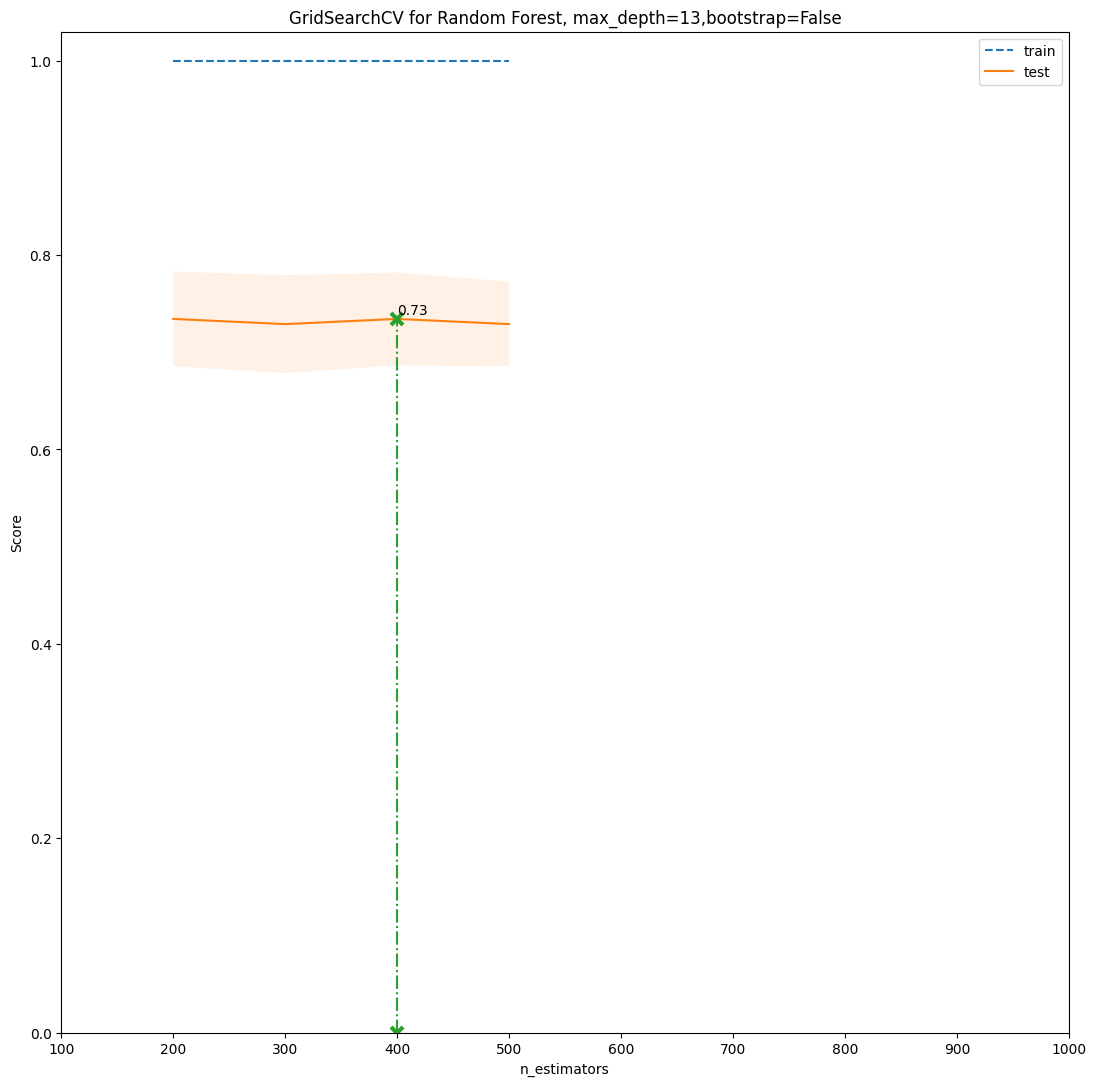

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV for Random Forest, max_depth=13,bootstrap=False", fontsize=12)

plt.xlabel("n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(100, 1000)
ax.set_ylim(0, 1.03)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_estimators"].data, dtype=float)


for sample, style in (("train", "--"), ("test", "-")):
    sample_score_mean = results['mean_%s_score' % sample]
    sample_score_std = results['std_%s_score' % sample]
    ax.fill_between(
        X_axis,
        sample_score_mean - sample_score_std,
        sample_score_mean + sample_score_std,
        alpha=0.1 if sample == "test" else 0
        # color=color,
    )
    ax.plot(
        X_axis,
        sample_score_mean,
        style,
        # color=color,
        # alpha=1 if sample == "test" else 0.7,
        label="%s" % sample,
    )

best_index = np.nonzero(results["rank_test_score"] == 1)[0][0]
best_score = results['mean_test_score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot(
    [
        X_axis[best_index],
    ]
    * 2,
    [0, best_score],
    linestyle="-.",
    # color=color,
    marker="x",
    markeredgewidth=3,
    ms=8,
)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()